In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import missingno as msno
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/My Drive/data science corizo/major project /sensor-data.csv'
data = pd.read_csv(data_path)
print(data.shape)


(1567, 592)


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [ ]:
data.head()


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


We can assume there are 590 independent processes that together add up to create a semiconductor and at the end of the process they are tagged as success or failure in terms of creating 1 new functional semiconductor unit.
There are quite a few NaN entries and entries which are equal to the value 0.
The 0s are not sparse you can see quite a few of them in continuation which may indicate an error or lack of data i/o.
We must either impute or drop them because these duplicate values will not help in determining/predicting target.
Lets find out which are the most important features in terms of predicting our target,and also the ones we can eliminate which have most of these error or missing values.
Also the datetime feature doesnt any significance here so we should be able to drop it without any problem.

In [ ]:
data.isnull().any().any()


True

In [ ]:
x = data.isnull().sum().sum()
print('total null value =' ,x)
data.isnull().sum()

total null value = 41951


Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [ ]:
data.describe()


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


As we can see the number of missing values are quite large and sometimes more than half the values of the columns are entirely missing, we can consider dropping them altogether as the inconsistensies in between the rows of processes will not help in predicting the target variable.
Some of the columns are entirely filled with the value of 0 which we should eliminate as well.
Some features even exhibit negative values and many may have outliers on the higher side as we can see from the gap between max and 75%

In [ ]:
data.dtypes.value_counts()


float64    590
object       1
int64        1
Name: count, dtype: int64

In [ ]:
Counter(data['Pass/Fail'])


Counter({-1: 1463, 1: 104})

104 vlaues belong to the fail Category and 1463 to Pass. Large Class imbalance can be seen.
We earlier saw a large number of missing values,Accurately imputing them will be a challenge plus it will be difficult to even verify so we should remove some features manually.

In [ ]:
empty_cols=data.columns[data.isna().mean()>=.50]
empty_cols.shape

(28,)

We can see that 28  columns have more than a half of the data missing, so we will be dropping them.



In [ ]:
data_df=data.drop(empty_cols,axis=1)
data_df.shape

(1567, 564)

In [ ]:
nunique = data_df.apply(pd.Series.nunique)
nunique

Time         1534
0            1520
1            1504
2             507
3             518
             ... 
586           322
587           260
588           120
589           611
Pass/Fail       2
Length: 564, dtype: int64

In [ ]:
const_cols = nunique[nunique == 1].index
const_cols.shape

(116,)

As we can see of the 564 remaining features 116 of them only have 1 unique value which indicates a faulty data across all batches and therefore we will frop these also.

In [ ]:
data_df=data_df.drop(const_cols,axis=1)
data_df.shape

(1567, 448)

The feature "Time" may or may not be useful in predicting the target, we can visually explore it to eee if it provides any meanigful data.

In [ ]:
data_df['year'] = pd.DatetimeIndex(data_df['Time']).year
data_df['month'] = pd.DatetimeIndex(data_df['Time']).month
data_df['date'] = pd.DatetimeIndex(data_df['Time']).day
data_df['week_day'] = pd.DatetimeIndex(data_df['Time']).weekday
data_df['start_time'] = pd.DatetimeIndex(data_df['Time']).time
data_df['hour'] = pd.DatetimeIndex(data_df['Time']).hour
data_df['min'] = pd.DatetimeIndex(data_df['Time']).minute
data_df=data_df.drop('Time',axis=1)

In [ ]:
data_df.head()

,0,1,2,3,4,6,7,8,9,10,...,588,589,Pass/Fail,year,month,date,week_day,start_time,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,NaN,NaN,-1,2008,7,19,5,11:55:00,11,55
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,0.0060,208.2045,-1,2008,7,19,5,12:32:00,12,32
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,0.0148,82.8602,1,2008,7,19,5,13:17:00,13,17
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,0.0044,73.8432,-1,2008,7,19,5,14:43:00,14,43
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,0.0044,73.8432,-1,2008,7,19,5,15:22:00,15,22


In [ ]:
year = data_df.year.unique()
month = data_df.month.unique()
date = data_df.date.unique()
week = data_df.week_day.unique()
print(f'unique no of years = {year}\nunique no of months = {month}\nunique no of date ={date}\nunique no of weeks = {week}')


unique no of years = [2008]
unique no of months = [ 7  1  2  3  4  5  6  8  9 10 11 12]
unique no of date =[19 20 21 22 23 25 27 28 29 30 31  8 13 15 16 17 18 24  9 14 26 10]
unique no of weeks = [5 6 0 1 2 4 3]


Data received is from all the months of the 2008 calendar year cycle. Although it is not recorded everyday of the month but we can see that production happens throughout the week even on Sundays.



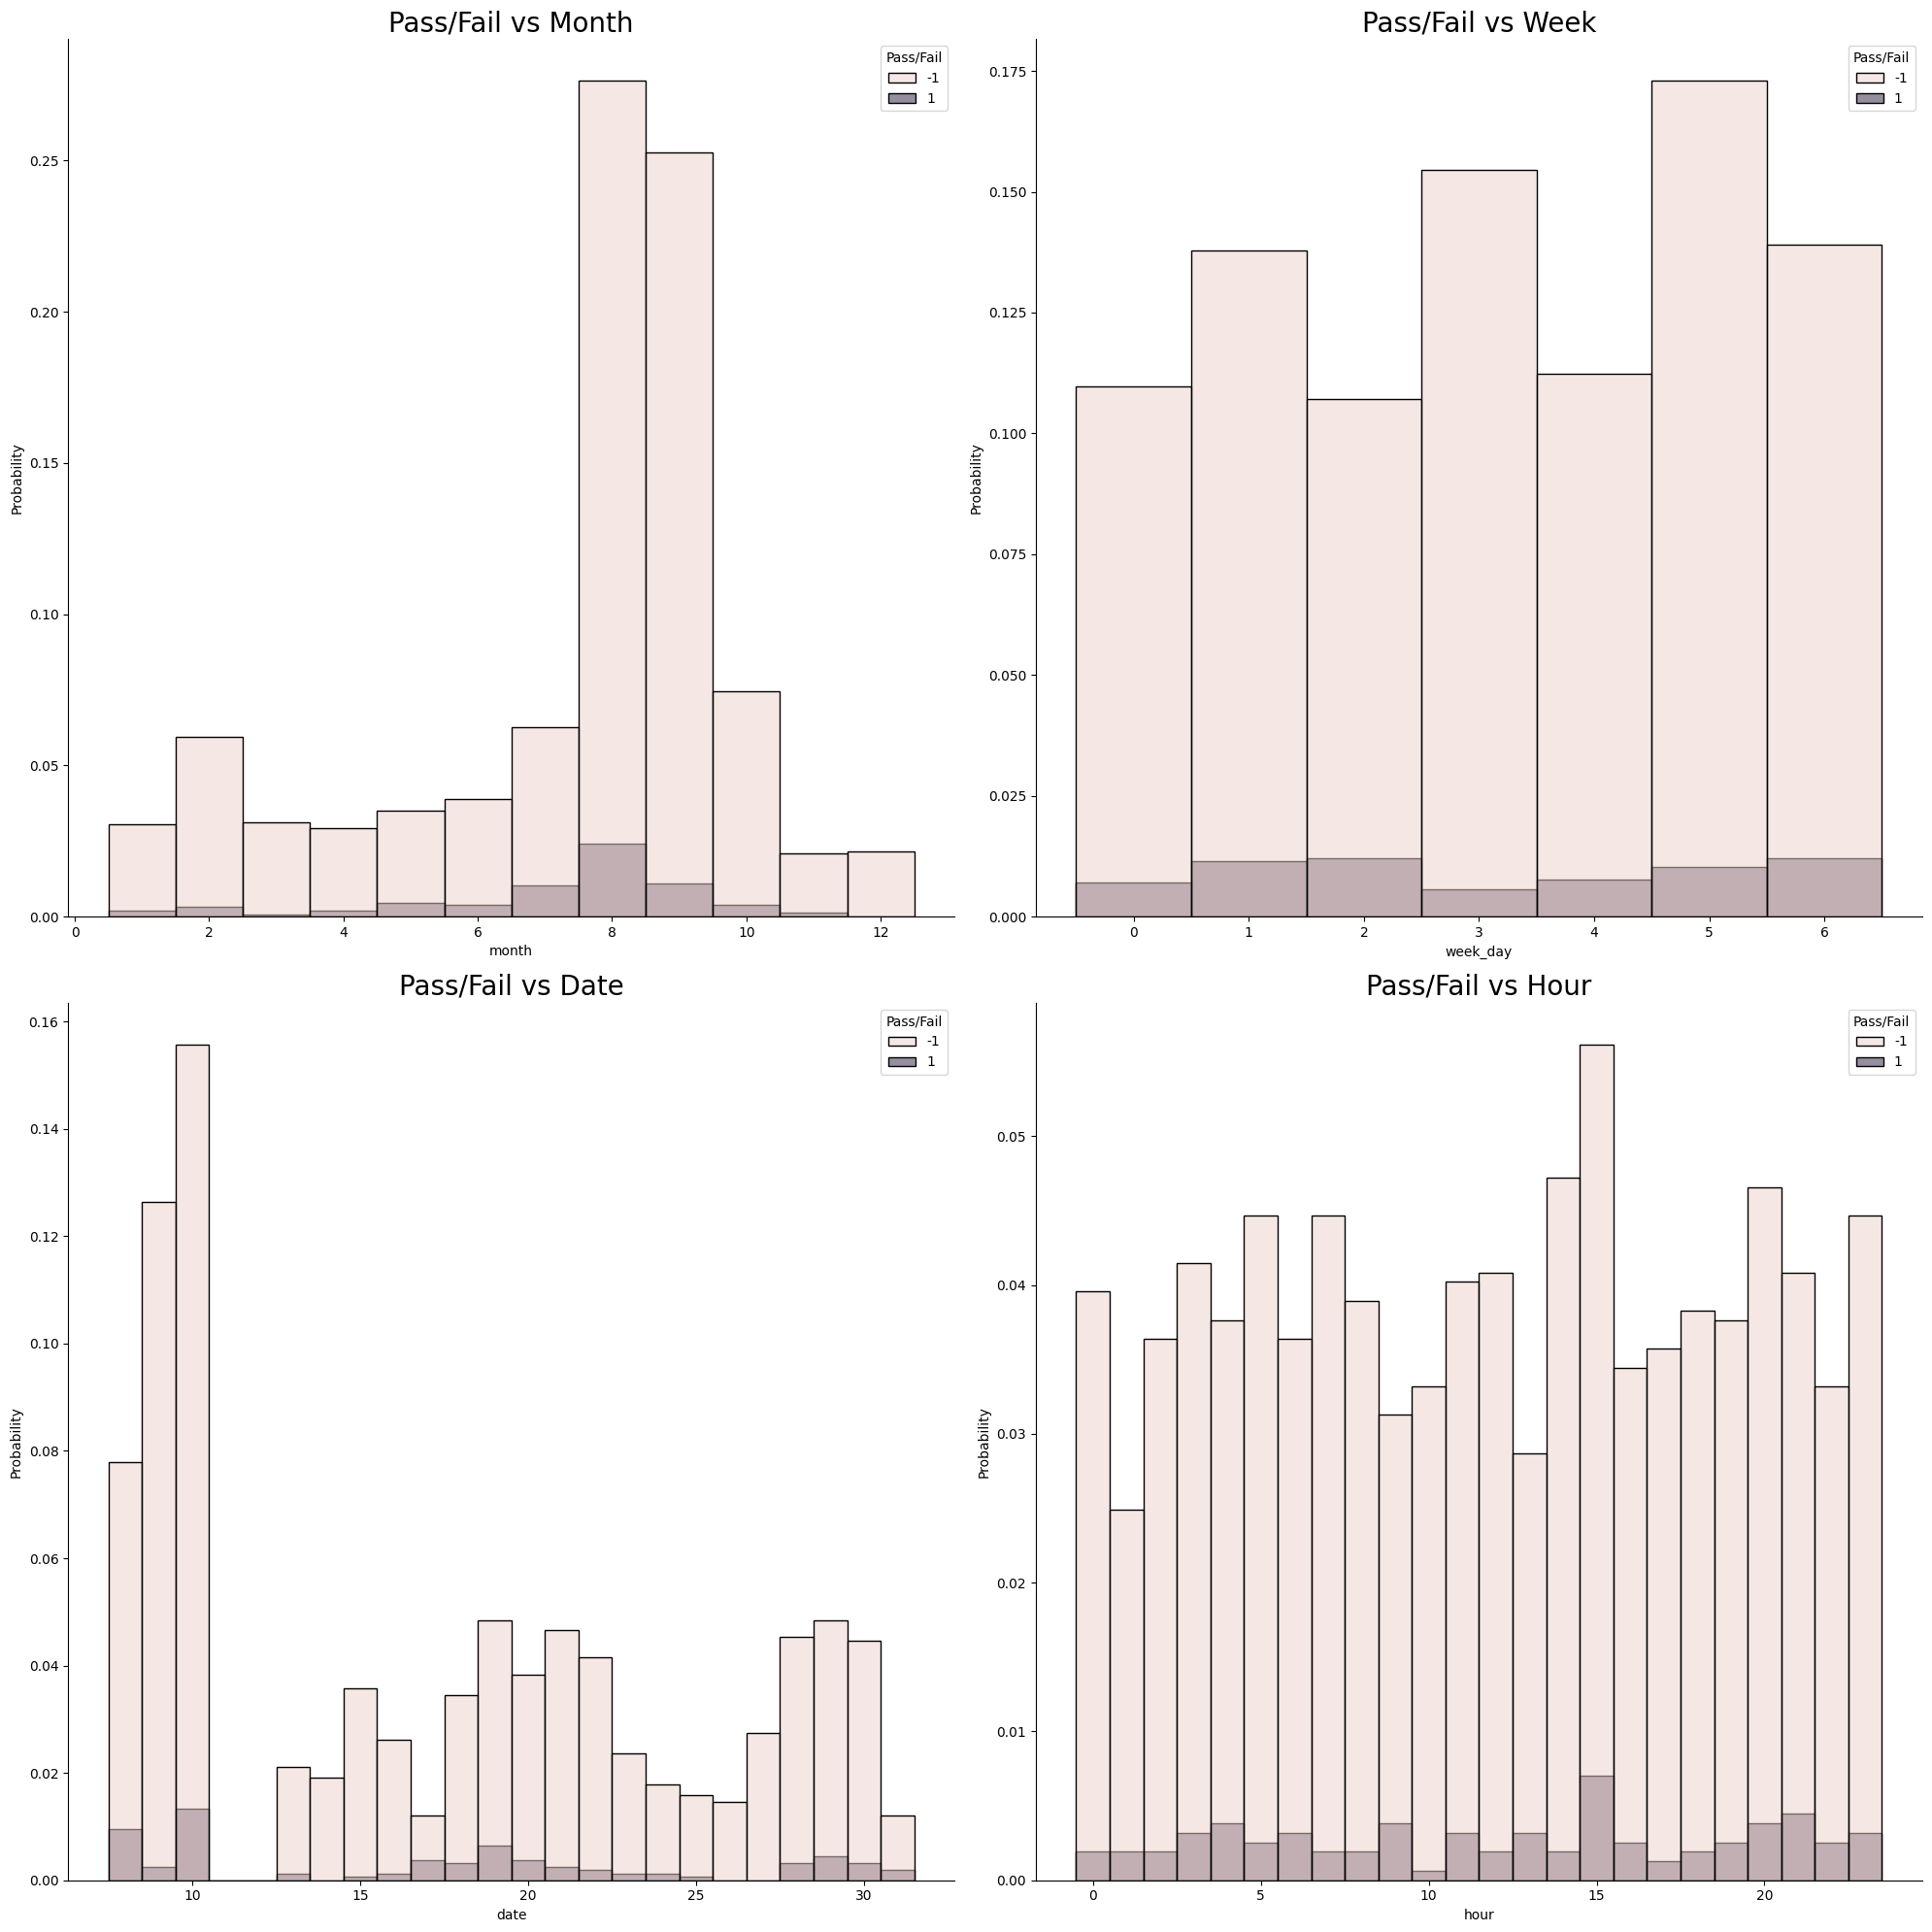

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.histplot(data=data_df, x="month", hue="Pass/Fail", stat="probability", discrete=True)
sns.despine(right=True, top=True)
plt.title('Pass/Fail vs Month', fontsize=20)

plt.subplot(2, 2, 2)
sns.histplot(data=data_df, x="week_day", hue="Pass/Fail", stat="probability", discrete=True)
sns.despine(right=True, top=True)
plt.title('Pass/Fail vs Week', fontsize=20)

plt.subplot(2, 2, 3)
sns.histplot(data=data_df, x="date", hue="Pass/Fail", stat="probability", discrete=True)
sns.despine(right=True, top=True)
plt.title('Pass/Fail vs Date', fontsize=20)

# Subplot 4: Pass/Fail vs
plt.subplot(2, 2, 4)
sns.histplot(data=data_df, x="hour", hue="Pass/Fail", stat="probability", discrete=True)
sns.despine(right=True, top=True)
plt.title('Pass/Fail vs Hour', fontsize=20)

plt.tight_layout()
plt.show()


On deeper analysis we can observe:
This is a 24/7 around the clock production facility working on all days of the year.
No significant pattern can be seen as such on a daily basis, except end of the weekday has a slightly higher value than most days.
Usually the first 10 days of every month is the busiest.
The production facility seems to be the busiest during the months of August and September, the abnormally high volumes can be a market response of the product.

These explorations help us understand the profile of the facility but do not provide significant insight into why a semiconductor failed in the production cyle.The distribution of success to failure follows the same distribution whether we analyse it hourly/daily/monthly or over the period of the entire year of 2008.Therefore we will drop these features.

In [ ]:
data_df1=data_df.drop(['year','month','date','week_day','start_time','hour','min'],axis = 1)


In [ ]:
data_df1.isnull().sum().sum()


10868

We are now left with fewer nan values which we can now consider imputing. At the started the dataset had 41951 missing values which we have reduced to 10868 along with dealing 116 faulty features. We can visually see with the graph that it has lesser gaps and those existing seem to be following a pattern therefore imputing an average value can make sense here

In [ ]:
empty_cols=data_df1.columns[data_df1.isna().mean()>=.15]
print(empty_cols.shape)
empty_cols

(24,)


Index(['112', '247', '385', '519', '546', '547', '548', '549', '550', '551',
       '552', '553', '554', '555', '556', '557', '562', '563', '564', '565',
       '566', '567', '568', '569'],
      dtype='object')

We can see that 24  columns have more than a quarter  of the data missing, so we will be dropping them too , to get a clan data set




In [ ]:
data_df2=data_df1.drop(empty_cols,axis=1)
data_df2.shape

(1567, 423)

In [ ]:
data_df2.isnull().sum().sum()


2704

As the number of  missing data approaches to 2700 from 40951 which is a small amount of we would be replacing the missing values with the means



In [ ]:
data_df2.fillna(data_df2.mean(), inplace=True)
data_df2.isnull().sum().sum()


0

In [ ]:
desc_stats = data_df2.describe()
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
                  0            1            2            3            4  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.480613    80.227793    29.380932   439.712852    56.103066   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.665000  2452.885000  2181.099950  1083.885800     1.017700   
50%    3011.840000  2498.910000  2200.955600  1287.353800     1.317100   
75%    3056.540000  2538.745000  2218.055500  1590.169900     1.529600   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

                 6            7            8            9           10  ...  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  ...   
mean    101.112908     0.121822     1.462862    -0.000841     0.000146  ...   
std       6.209271     0.008936     0.073849     0.015107     0.009296 

### Univariate Analysis


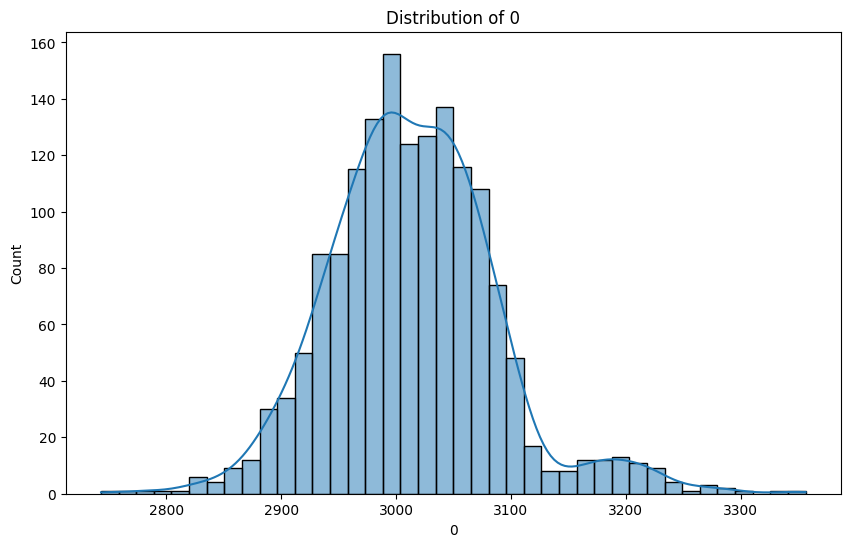

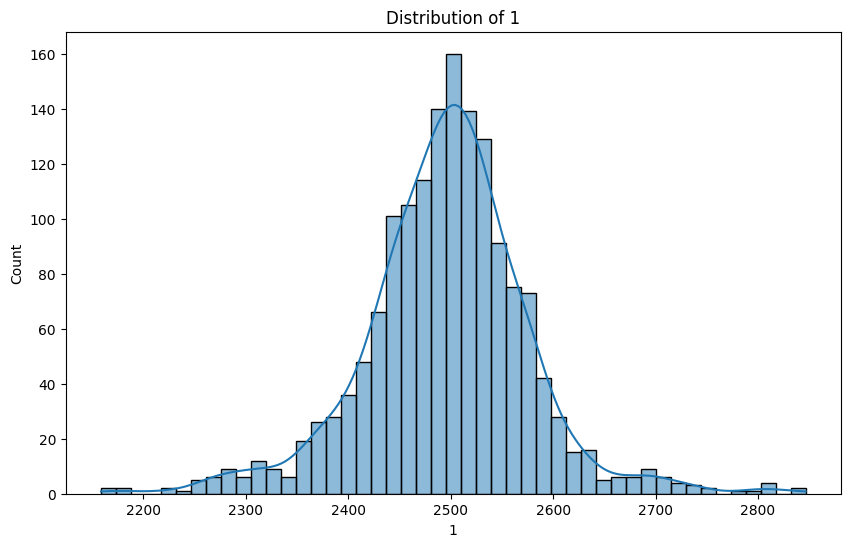

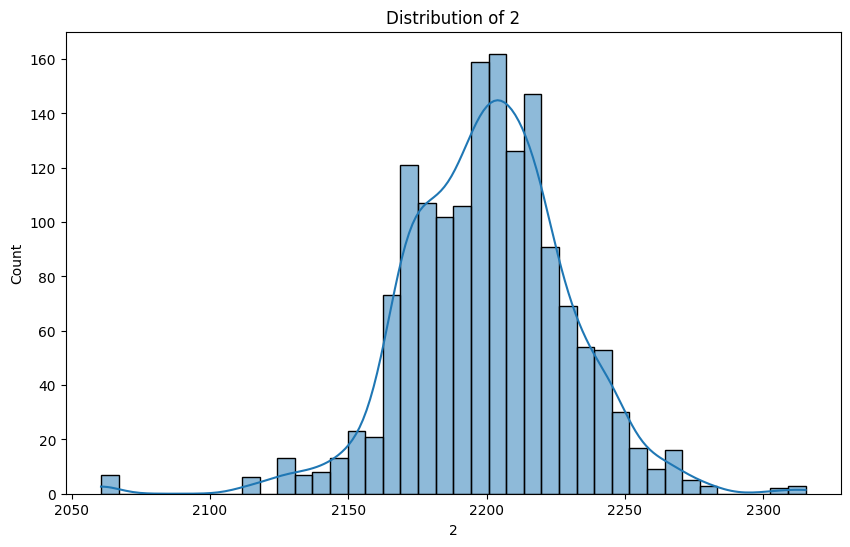

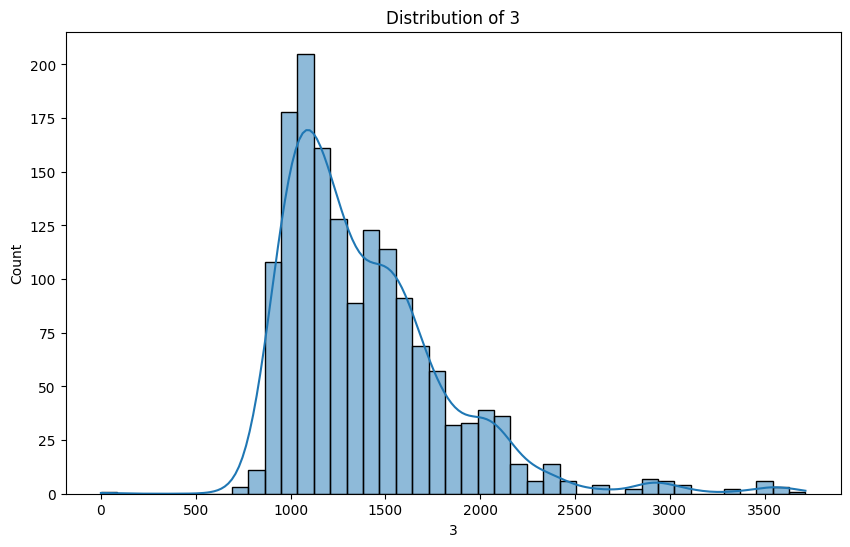

In [ ]:
sample_features = data_df2.columns[:4]
for feature in sample_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()



- **Histogram for Feature 0**

  The histogram shows the distribution of values for the first feature (labeled "0").
  The distribution appears to be roughly normal (bell-shaped), indicating that most of the data points are centered around the mean value with fewer      data points towards the tails.

- **Histogram for Feature 1**

  The histogram for the second feature (labeled "1") also shows a roughly normal distribution.
  This indicates that the feature has a symmetrical distribution with a peak around the mean value.

- **Histogram for Feature 2**

  The histogram for the third feature (labeled "2") shows a slightly more complex distribution, with some noticeable skewness.
  There are peaks and troughs suggesting the presence of multiple modes or clusters within the data.

- **Histogram for Feature 3**

  The histogram for the fourth feature (labeled "3") shows a skewed distribution.
  There is a higher frequency of lower values, with a tail extending towards higher values, indicating a right-skewed distribution.

 ### Bivariate Analysis

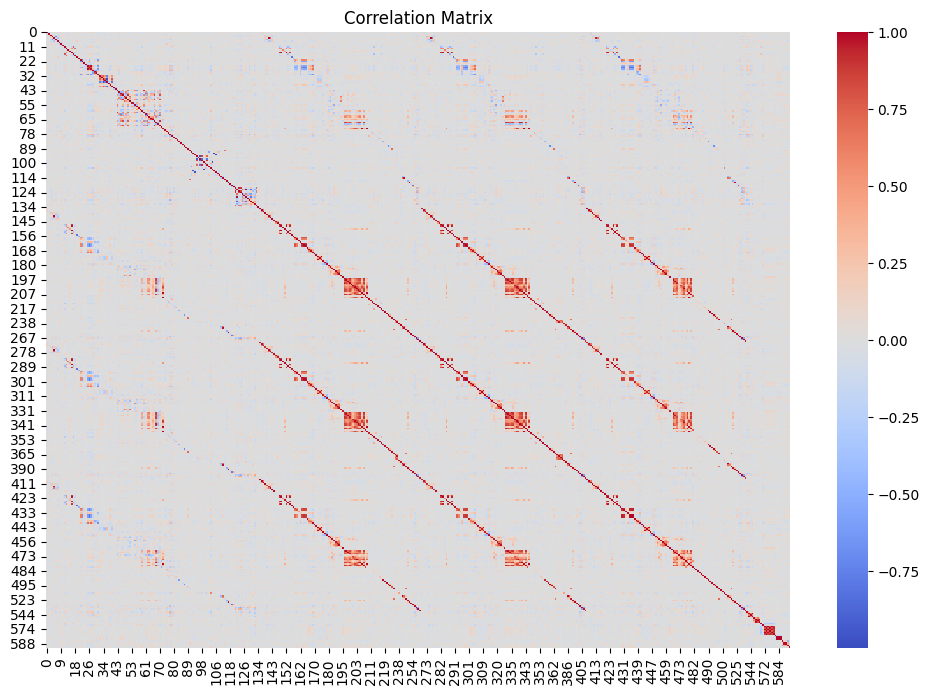

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_df2.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

**Correlation Matrix:**

The heatmap shows the correlation coefficients between pairs of features in the dataset.
Positive correlation (closer to 1) indicates that as one feature increases, the other feature tends to increase as well.
Negative correlation (closer to -1) indicates that as one feature increases, the other feature tends to decrease.
Values close to 0 indicate little to no linear relationship between the features.
In this heatmap, we can observe various shades of colors representing the strength and direction of correlations. Darker colors (red) indicate stronger positive correlations, while lighter colors (blue) indicate stronger negative correlations.
Highly correlated features may indicate redundancy and could be considered for dimensionality reduction.

### Multivariate Analysis

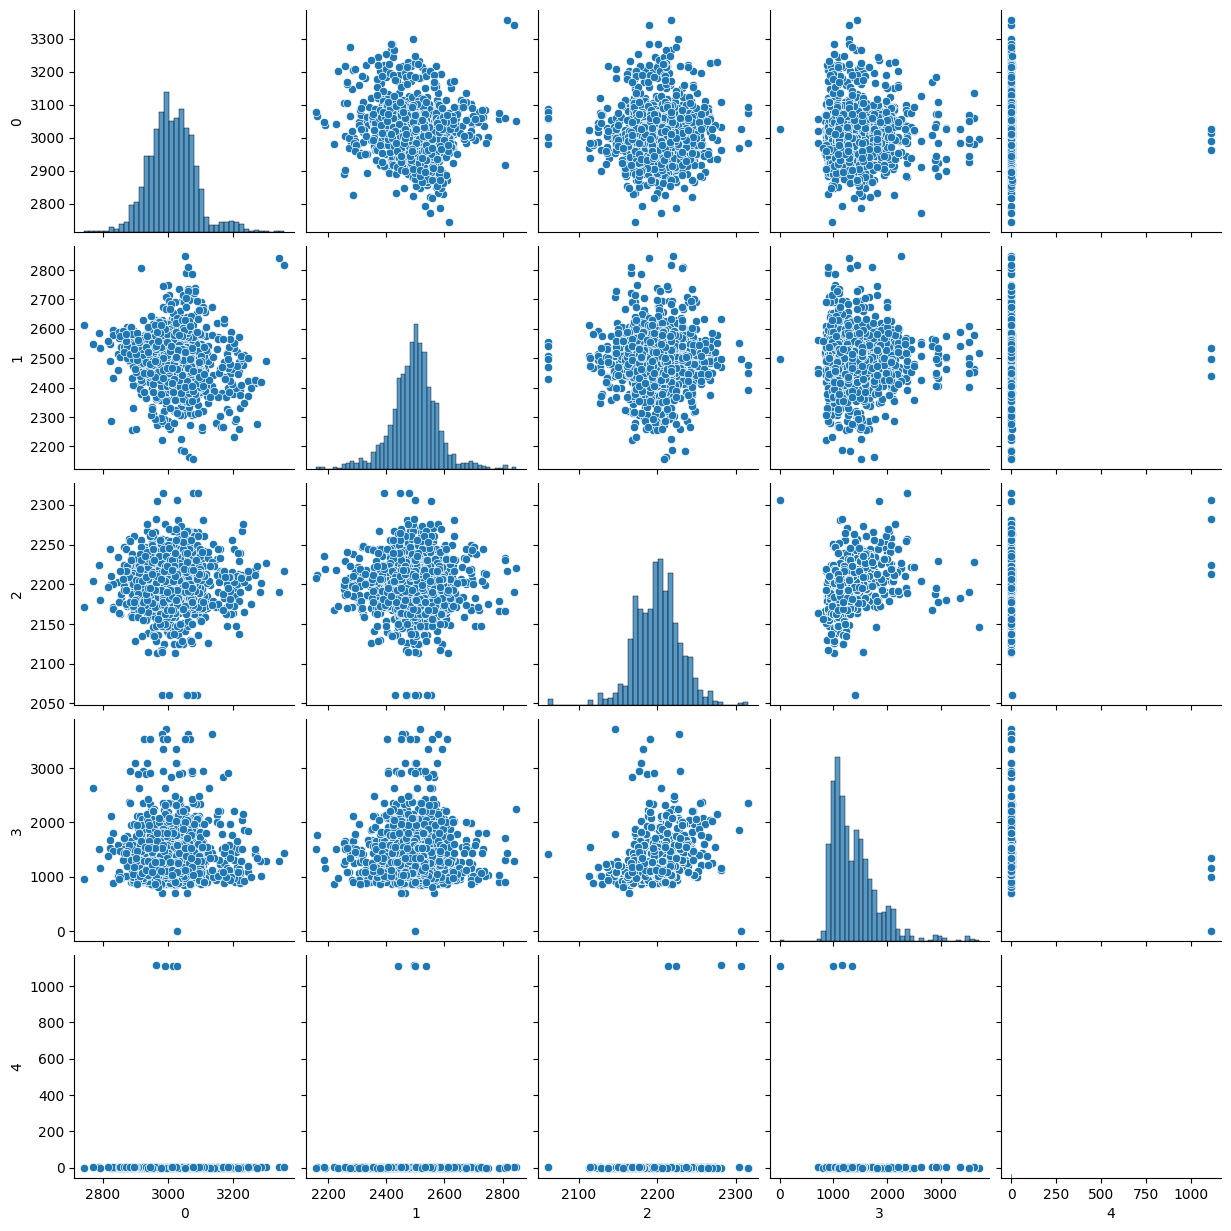

In [ ]:
plt.show()

The pairplot provides a scatterplot matrix showing relationships between pairs of features.
Diagonal plots show the distribution of individual features, similar to the histograms in the first image.
Off-diagonal plots show scatterplots for each pair of features, helping to visualize potential linear relationships or patterns.
This visualization is particularly useful for identifying clusters, outliers, and correlations between features.
In this pairplot, we can see that most scatterplots exhibit a random spread, suggesting weak linear relationships between the features shown.

In [ ]:
X = data_df2.drop(columns=['Pass/Fail'])
y = data_df2['Pass/Fail']

X.head(), y.head()

(         0        1          2          3       4         6       7       8  \
 0  3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  0.1242  1.5005   
 1  3095.78  2465.14  2230.4222  1463.6606  0.8294  102.3433  0.1247  1.4966   
 2  2932.61  2559.94  2186.4111  1698.0172  1.5102   95.4878  0.1241  1.4436   
 3  2988.72  2479.90  2199.0333   909.7926  1.3204  104.2367  0.1217  1.4882   
 4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.3967  0.1235  1.5031   
 
         9      10  ...     576      577     582     583     584      585  \
 0  0.0162 -0.0034  ...  1.6765  14.9509  0.5005  0.0118  0.0035   2.3630   
 1 -0.0005 -0.0148  ...  1.1065  10.9003  0.5019  0.0223  0.0055   4.4447   
 2  0.0041  0.0013  ...  2.0952   9.2721  0.4958  0.0157  0.0039   3.1745   
 3 -0.0124 -0.0033  ...  1.7585   8.5831  0.4990  0.0103  0.0025   2.0544   
 4 -0.0031 -0.0072  ...  1.6597  10.9698  0.4800  0.4766  0.1045  99.3032   
 
         586       587       588         589  
 0  0.0

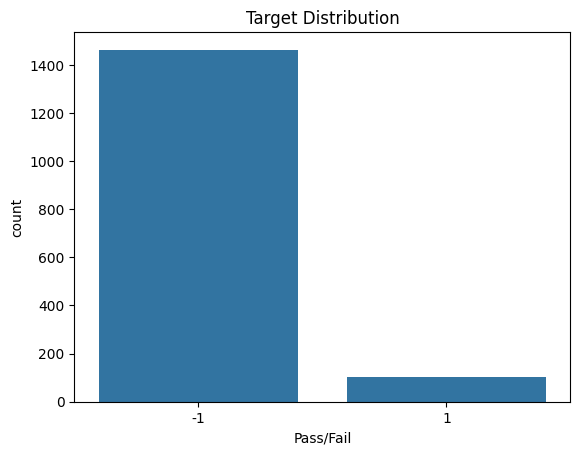

((2926, 422), (2926,))

In [ ]:
target_distribution = y.value_counts()
sns.countplot(x=y)
plt.title('Target Distribution')
plt.show()

if target_distribution.min() / target_distribution.max() < 0.5:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    X_resampled, y_resampled = X, y

X_resampled.shape, y_resampled.shape


We visualized the target distribution using a bar plot. It shows a significant imbalance, with many more instances of -1 (pass) compared to 1 (fail).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((2340, 422), (586, 422))

The training set has 2340 samples and 422 features.
The test set has 586 samples and 422 features.
These steps ensure that we have balanced and standardized data ready for model training and testing.

In [ ]:
train_stats = pd.DataFrame(X_train_scaled).describe()
test_stats = pd.DataFrame(X_test_scaled).describe()
original_stats = pd.DataFrame(scaler.transform(X)).describe()

train_stats, test_stats, original_stats


(                0             1             2             3             4    \
 count  2.340000e+03  2.340000e+03  2.340000e+03  2.340000e+03  2.340000e+03   
 mean   7.150975e-16  6.285570e-16 -8.676061e-15  2.064825e-16 -9.109522e-18   
 std    1.000214e+00  1.000214e+00  1.000214e+00  1.000214e+00  1.000214e+00   
 min   -3.675267e+00 -4.749827e+00 -5.092620e+00 -1.751393e+00 -5.221480e-02   
 25%   -6.688738e-01 -5.360812e-01 -6.439925e-01 -7.279666e-01 -4.233686e-02   
 50%   -1.313123e-01  3.350588e-02 -5.325615e-02 -2.309184e-01 -3.627386e-02   
 75%    5.700722e-01  5.383095e-01  5.556452e-01  5.212777e-01 -3.204980e-02   
 max    4.800158e+00  4.930803e+00  4.194276e+00  6.173834e+00  2.794953e+01   
 
                 5             6             7             8             9    \
 count  2.340000e+03  2.340000e+03  2.340000e+03  2.340000e+03  2.340000e+03   
 mean   6.285570e-16 -2.400359e-15 -2.604185e-15 -3.340158e-17 -7.591269e-18   
 std    1.000214e+00  1.000214e+00  1.

From above data we can  Check if the train and test data have similar statistical characteristics when compared with original data.
the original data doesnot share much similar characteristics to the train and test data

### Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f'Cross-Validation Accuracy: {cv_scores.mean()}')
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
y_pred = grid_search.predict(X_test_scaled)

report = classification_report(y_test, y_pred)
print(report)

Cross-Validation Accuracy: 0.9888888888888889
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

          -1       0.52      0.98      0.68       306
           1       0.44      0.01      0.03       280

    accuracy                           0.52       586
   macro avg       0.48      0.50      0.35       586
weighted avg       0.48      0.52      0.37       586



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Naive Bayes Model


In [ ]:
nb_model = GaussianNB()

nb_model.fit(X_train_scaled, y_train)

cv_scores_nb = cross_val_score(nb_model, X_train_scaled, y_train, cv=5)

print(f'Naive Bayes Cross-Validation Accuracy: {cv_scores_nb.mean()}')
param_grid_nb = {
    'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]
}

grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, cv=5, n_jobs=-1, verbose=2)

grid_search_nb.fit(X_train_scaled, y_train)

print(f'Best Parameters for Naive Bayes: {grid_search_nb.best_params_}')
y_pred_nb = grid_search_nb.predict(X_test_scaled)

report_nb = classification_report(y_test, y_pred_nb)
print(report_nb)

Naive Bayes Cross-Validation Accuracy: 0.6047008547008547
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters for Naive Bayes: {'var_smoothing': 1e-06}
              precision    recall  f1-score   support

          -1       0.98      0.19      0.31       306
           1       0.53      1.00      0.69       280

    accuracy                           0.57       586
   macro avg       0.76      0.59      0.50       586
weighted avg       0.77      0.57      0.49       586



### SVM Model

In [ ]:
svm_model = SVC()
cv_scores_svc = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)

print(f'SVM Cross-Validation Accuracy: {cv_scores_svc.mean()}')
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_scaled, y_train)

print(f'Best Parameters for SVM: {grid_search_svm.best_params_}')

y_pred_svm = grid_search_svm.predict(X_test_scaled)
report_svm = classification_report(y_test, y_pred_svm)
print(report_svm)


SVM Cross-Validation Accuracy: 0.9888888888888889
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       306
           1       0.99      1.00      1.00       280

    accuracy                           1.00       586
   macro avg       1.00      1.00      1.00       586
weighted avg       1.00      1.00      1.00       586



### Comparison 

In [ ]:
# Random Forest Model
rf_train_accuracy = grid_search.score(X_train_scaled, y_train)
rf_test_accuracy = grid_search.score(X_test_scaled, y_test)
print(f'Random Forest Train Accuracy: {rf_train_accuracy}')
print(f'Random Forest Test Accuracy: {rf_test_accuracy}')

# SVM Model
svm_train_accuracy = grid_search_svm.score(X_train_scaled, y_train)
svm_test_accuracy = grid_search_svm.score(X_test_scaled, y_test)
print(f'SVM Train Accuracy: {svm_train_accuracy}')
print(f'SVM Test Accuracy: {svm_test_accuracy}')

# Naive Bayes Model
nb_train_accuracy = grid_search_nb.score(X_train_scaled, y_train)
nb_test_accuracy = grid_search_nb.score(X_test_scaled, y_test)
print(f'Naive Bayes Train Accuracy: {nb_train_accuracy}')
print(f'Naive Bayes Test Accuracy: {nb_test_accuracy}')


Random Forest Train Accuracy: 0.49786324786324787
Random Forest Test Accuracy: 0.5204778156996587


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SVM Train Accuracy: 1.0
SVM Test Accuracy: 0.9965870307167235
Naive Bayes Train Accuracy: 0.6098290598290599
Naive Bayes Test Accuracy: 0.5733788395904437


In [ ]:
import joblib

joblib_file = "svm_model.pkl"
joblib.dump(svm_model, joblib_file)
print(f"Model saved as {joblib_file}")


Model saved as svm_model.pkl


## Conclusion

After training and evaluating three different models - Random Forest, SVM, and Naive Bayes - the SVM model was selected as the best-performing model based on its high accuracy on both the training and test datasets. The SVM model achieved a train accuracy of 1.0 and a test accuracy of 0.9966, indicating excellent performance on the given dataset.

However, there are some concerns about potential overfitting, as indicated by the perfect training accuracy. To further validate the model's performance, additional metrics such as precision, recall, and F1 score should be considered. Cross-validation and regularization techniques could also be employed to mitigate overfitting.

### Future Improvements

- **Model Validation**: Implement cross-validation to ensure the model generalizes well to unseen data.
- **Feature Engineering**: Explore additional feature engineering techniques to improve model performance.
- **Parameter Tuning**: Further fine-tune hyperparameters to find the optimal settings for the models.
- **Ensemble Methods**: Consider using ensemble methods to combine the strengths of multiple models for better performance.
- **Handling Imbalanced Data**: If the data is imbalanced, techniques such as SMOTE or adjusting class weights should be applied to improve model           performance.
